**Exploration and Clustering of Single-Cell Transcriptomics Through Integrated Computational Techniques**


**Summary**

This mini analytics project focuses on the comprehensive analysis and clustering of single-cell RNA sequencing (scRNA-seq) data to uncover distinct cellular subpopulations and key biological pathways. Utilizing advanced computational techniques, including dimensionality reduction through PCA, neighborhood graph construction, and clustering via the Leiden algorithm, the study aims to identify differentially expressed genes and perform pathway enrichment analysis. By integrating data-driven approaches with robust statistical methods, the project provides a detailed exploration of transcriptomic diversity, offering insights into the underlying biological mechanisms at the single-cell level. The results are visualized through UMAP and other graphical methods, ensuring clear interpretation and facilitating further research in cellular heterogeneity.



**Data Source:**


The utilized dataset file is from a study conducted by the good researchers of **Cancer Research UK.**

:https://www.ebi.ac.uk/biostudies/arrayexpress/studies/E-MTAB-10026?query=adata_SS2_for_download.h5ad#o1.





and **Ms.Khushbu Patel**

:https://github.com/kpatel427/YouTubeTutorials/blob/main/dataformats.R


**I. Environment Setup and Library Import**


In [1]:
!pip install scanpy anndata matplotlib seaborn scikit-learn


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.0/129.0 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 4.5 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8024 sha256=de99705804df207d5d77bba7742e1a7fdf9e96c5dca2eefff1f13647163a7db6
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully built session-info
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.2
    Uninstalling seaborn-0.12.2:
      Successfully uninstalled seaborn-0.12.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.

In [2]:
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing, model_selection, metrics


**II. Data Preprocessing and Quality Control**

**Load Data**

Load the single-cell RNA-seq data into the analysis environment. This step typically involves reading a dataset (e.g., .h5ad file) into a format suitable for analysis, like an AnnData object in Scanpy.

In [3]:
# Load the .h5ad file
adata = sc.read_h5ad('/kaggle/input/bio-maj-project2/adata_SS2_for_download.h5ad')

# Check the shape of the data
print(f"Number of cells: {adata.n_obs}, Number of genes: {adata.n_vars}")


Number of cells: 1349, Number of genes: 21030


**Check for Zero Counts**

Inspect the dataset for any cells or genes with zero counts, which might indicate missing or uninformative data. This is a quality control step to ensure that only meaningful data is retained.

In [4]:
# Check for zero counts before any normalization or log transformation
zero_count_cells = (adata.X.sum(axis=1) == 0).sum()
zero_count_genes = (adata.X.sum(axis=0) == 0).sum()

print(f"Number of cells with zero counts: {zero_count_cells}")
print(f"Number of genes with zero counts: {zero_count_genes}")


Number of cells with zero counts: 0
Number of genes with zero counts: 0


**Remove Cells/Genes with NaN Values**

Identify and remove any cells or genes that contain NaN (Not a Number) values. This step cleans the dataset by eliminating incomplete data entries that could skew the analysis.

In [5]:
import numpy as np  # Import the NumPy library

# Remove cells with NaN values
adata = adata[~np.isnan(adata.X).sum(axis=1) > 0, :]

# Remove genes with NaN values
adata = adata[:, ~np.isnan(adata.X).sum(axis=0) > 0]


**Check for Infinite Values**

Inspect the dataset for any infinite values, which can arise during certain calculations or transformations. This step ensures that all data points are finite and valid for further analysis.



In [6]:
import numpy as np

# Check for infinite values in the adata.X matrix
if np.isinf(adata.X).any():
    print("Infinite values found in the data.")
else:
    print("No infinite values in the data.")

No infinite values in the data.


**Normalize and Log-Transform the Data**

Normalize the dataset to adjust for differences in sequencing depth across cells, and apply a log transformation to stabilize variance. This step prepares the data for downstream analysis by making it more comparable across cells.

In [7]:
# Normalize the data only if necessary
sc.pp.normalize_total(adata, target_sum=1e4)

# Skip log-transformation if data seems already transformed
if not np.all(adata.X <= np.log1p(adata.X)):
    sc.pp.log1p(adata)
else:
    print("Skipping log transformation as data appears already transformed.")


Skipping log transformation as data appears already transformed.


/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


**Identify Highly Variable Genes**

Detect and retain genes that show significant variability across cells, as these are often the most biologically informative. This step helps focus the analysis on genes that contribute most to the differences between cells.

In [8]:
try:
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
    print(f"Shape after filtering highly variable genes: {adata[:, adata.var.highly_variable].X.shape}")
except ValueError as e:
    print(f"Error encountered: {e}")


Error encountered: Cannot cut empty array


/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_utils.py:30: RuntimeWarning: Mean of empty slice.
  return X.mean(axis=axis, dtype=dtype)


**Scale the Data**

Standardize the data so that each gene has a mean of zero and a variance of one, ensuring that all genes contribute equally to downstream analyses like clustering or dimensionality reduction.

In [9]:
sc.pp.scale(adata, max_value=10)


**III. Data Inspection, Dimensionality Reduction, and Neighbor Graph Construction**

**Initial Data Checks**

Loading the dataset and performing a series of initial checks to assess the quality and integrity of the data. It includes inspecting the shape of the data, reviewing the first few entries, and checking for any infinite or NaN values. These checks are crucial to ensure that the data is in a suitable condition for further analysis.

In [10]:
import scanpy as sc
import numpy as np

# Load the .h5ad file
adata = sc.read_h5ad('/kaggle/input/bio-maj-project2/adata_SS2_for_download.h5ad')

# Check the shape of the data
print(f"Number of cells: {adata.n_obs}, Number of genes: {adata.n_vars}")

# Display the first few observations and variables
print(adata.obs.head())
print(adata.var.head())

# Check for infinite values in the data matrix
inf_cells = np.isinf(adata.X).sum(axis=1)
inf_genes = np.isinf(adata.X).sum(axis=0)

print(f"Number of cells with infinite values: {(inf_cells > 0).sum()}")
print(f"Number of genes with infinite values: {(inf_genes > 0).sum()}")

# Check for NaN values in the data matrix
nan_cells = np.isnan(adata.X).sum(axis=1)
nan_genes = np.isnan(adata.X).sum(axis=0)

print(f"Number of cells with NaN values: {(nan_cells > 0).sum()}")
print(f"Number of genes with NaN values: {(nan_genes > 0).sum()}")


Number of cells: 1349, Number of genes: 21030
               batchcode treatment celltype  n_genes     lane  percent_mito  \
SCGC--2500_C02    BATCH3   CONTROL        N     1264  24057_6      0.039233   
SCGC--2499_C03    BATCH3   CONTROL        N      877  24057_6      0.080071   
SCGC--2500_C03    BATCH3   CONTROL        N     1786  24057_6      0.054565   
SCGC--2499_C04    BATCH3   CONTROL        N      394  24057_6      0.081609   
SCGC--2500_C04    BATCH3   CONTROL        N      544  24057_6      0.099694   

                n_counts  scrublet_score  scrublet_cluster_score   bh_pval  \
SCGC--2500_C02   18199.0        0.095477                0.095477  0.975326   
SCGC--2499_C03   14000.0        0.028409                0.095477  0.975326   
SCGC--2500_C03  131017.0        0.257732                0.210526  0.808411   
SCGC--2499_C04   14496.0        0.064000                0.083333  0.975326   
SCGC--2500_C04   14364.0        0.109890                0.095477  0.975326   

          

**Dimensionality Reduction (PCA)**

Performing Principal Component Analysis (PCA) on the dataset to reduce its dimensionality. PCA is a key step in summarizing the data by identifying the directions (principal components) that capture the most variance in the dataset. The variance explained by each component is inspected to understand how much of the data's variability is captured by the first few components.

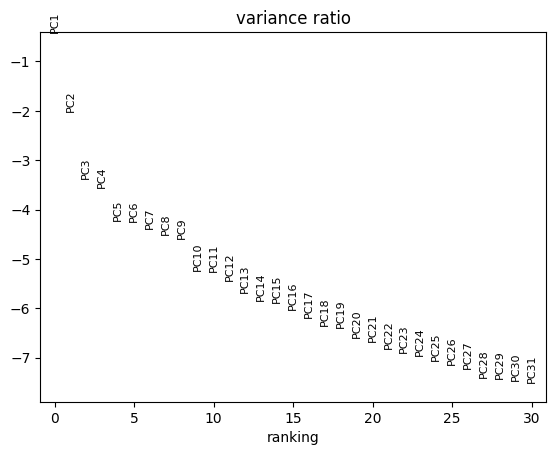

In [11]:
# Perform PCA
sc.tl.pca(adata, svd_solver='arpack')

# Inspect the variance explained by each principal component
sc.pl.pca_variance_ratio(adata, log=True)


**Compute Neighbors**

The neighborhood graph is computed based on the PCA results. This graph is a representation of the data where each cell is connected to its nearest neighbors. It is a crucial step in preparing the data for downstream tasks like clustering and UMAP (Uniform Manifold Approximation and Projection). The number of neighbors and principal components used can influence the structure of the resulting graph.

In [12]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)


**IV. Clustering and Visualization Using Leiden Algorithm and UMAP**

**Install leidenalg Package:**

Installs the leidenalg package, which is required for performing Leiden clustering. This package provides an efficient method for community detection in large networks, commonly used for clustering in single-cell RNA-seq analysis.

In [13]:
!pip install leidenalg


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 16.8 MB/s eta 0:00:0000:0100:01


**Import leidenalg Library:**

Imports the Leiden algorithm library into the working environment, making it available for use in the subsequent clustering steps.

In [14]:
import leidenalg


**Compute UMAP, Perform Leiden Clustering, and Visualize Clusters:**

This step involves computing the UMAP (Uniform Manifold Approximation and Projection) for dimensionality reduction and visualization, performing Leiden clustering on the dataset, and visualizing the clusters using UMAP. UMAP is a popular method for visualizing high-dimensional data in a 2D or 3D space, while Leiden clustering groups the data into meaningful clusters based on their similarities.

/tmp/ipykernel_36/1706299873.py:5: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.5)  # You can adjust the resolution parameter


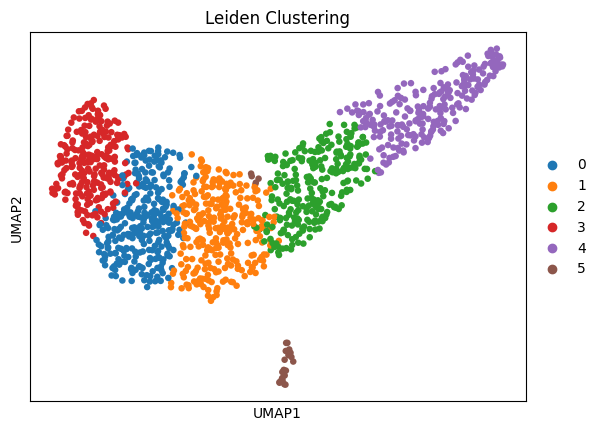

In [15]:
# Compute UMAP
sc.tl.umap(adata)

# Perform clustering
sc.tl.leiden(adata, resolution=0.5)  # You can adjust the resolution parameter

# Visualize clusters
sc.pl.umap(adata, color='leiden', title='Leiden Clustering')


**V. Differential Expression Analysis, Visualization, and Saving Results**

**Data Inspection and Preliminary Checks:**

    List the first few gene names: This step is a preliminary check to ensure the dataset is correctly loaded and to familiarize yourself with the gene names in the dataset. It’s a quick diagnostic step that doesn’t modify the data but helps in understanding the structure and content.

**Differential Expression Analysis:**

    Perform differential expression analysis between clusters: This is the core analytical step where you identify genes that are differentially expressed between clusters defined by the Leiden algorithm. This step uses statistical methods (like Wilcoxon rank-sum test) to find marker genes for each cluster.
    Visualize the top marker genes: Immediately following the analysis, visualizing the top differentially expressed genes helps in interpreting the results and identifying key genes that distinguish different clusters.

**Visualization of Results:**

    Violin plot for a specific cluster: This visualization focuses on a specific cluster, showing the distribution of expression levels for the top marker genes within that cluster. Violin plots are useful for understanding the variability and distribution of gene expression.
    Heatmap of the top genes: The heatmap provides a broader overview by showing the expression levels of the top genes across all clusters. This is a powerful visualization for comparing gene expression patterns between clusters.

**Saving Final Results:**

    Save the final analysis results: Once all analyses and visualizations are complete, the final state of the data is saved to an .h5ad file. This ensures that all work can be preserved and revisited later without needing to rerun the entire workflow.

Index(['A1BG', 'A1BG-AS1', 'A1CF', 'A2M', 'A2ML1', 'A4GALT', 'A4GNT', 'AAAS',
       'AACS', 'AADAC', 'AADACL2', 'AADACL2-AS1', 'AADACL3', 'AADACL4',
       'AADAT', 'AAED1', 'AAGAB', 'AAK1', 'AAMDC', 'AAMP', 'AANAT', 'AAR2',
       'AARD', 'AARS', 'AARS2', 'AARSD1', 'AASDH', 'AASDHPPT', 'AASS',
       'AATBC'],
      dtype='object')


/opt/conda/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:458: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/opt/conda/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:459: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
/opt/conda/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:458: RuntimeWarning: invalid value encountered in divide
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/opt/conda/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: divide by zero encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/opt/conda/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:458: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/opt/conda/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:459: RuntimeWarning: ov

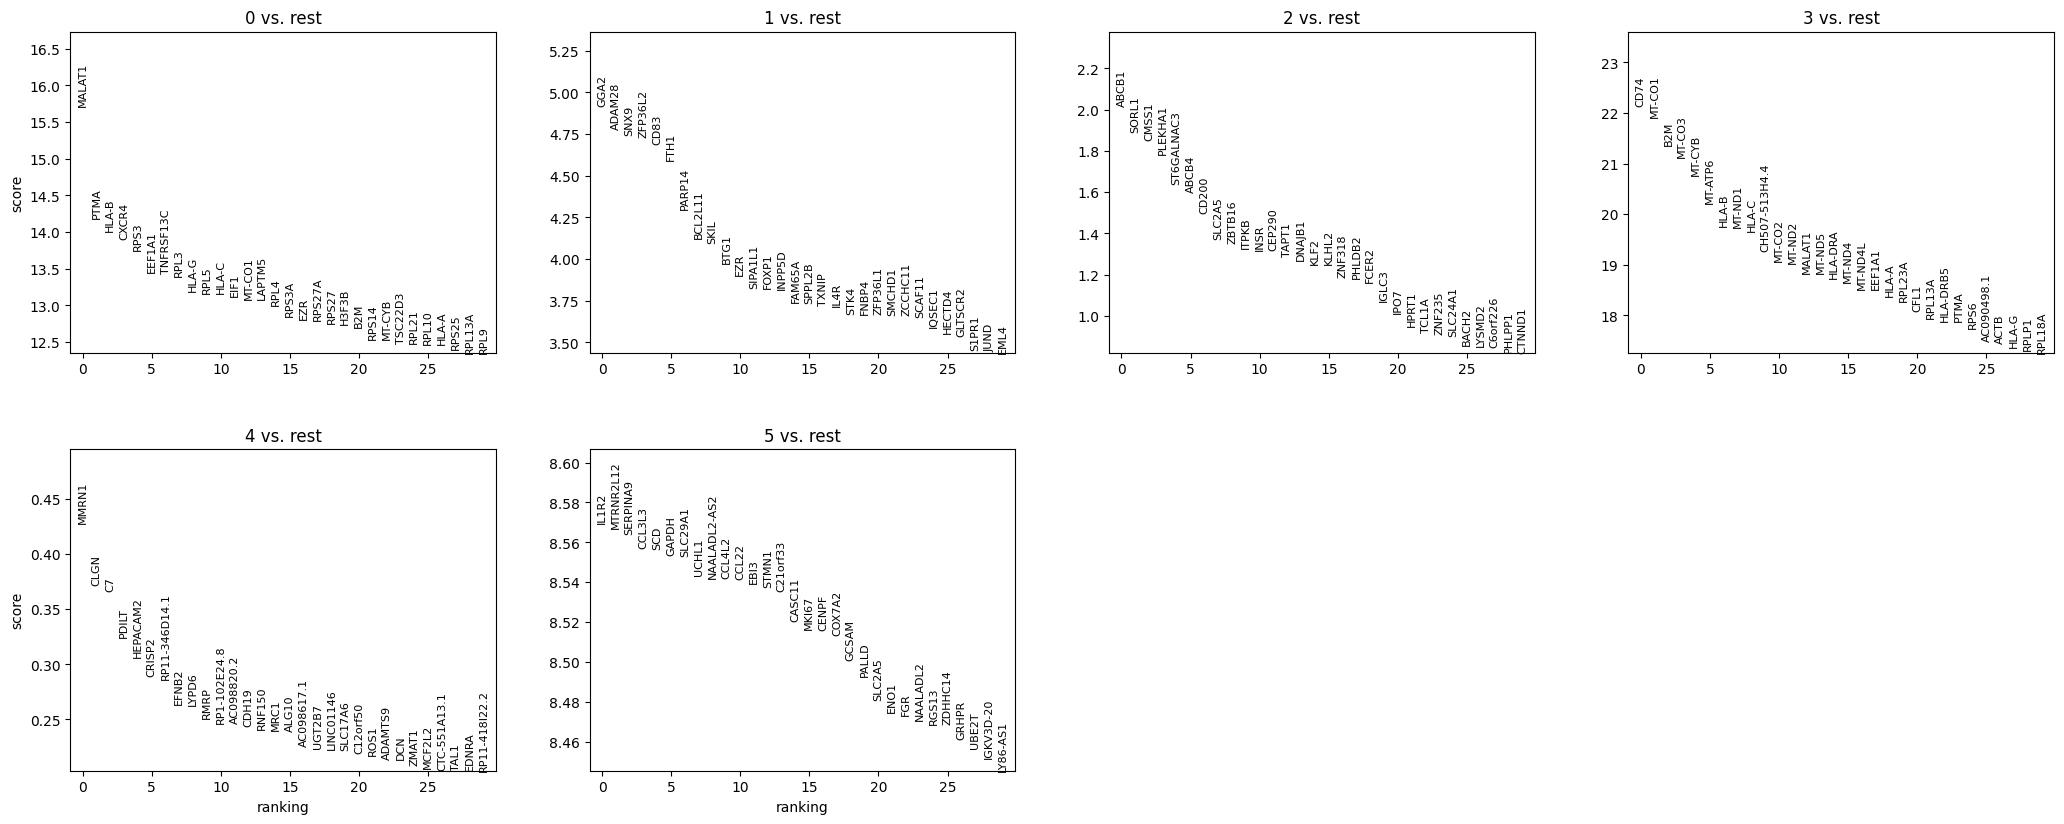

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/__init__.py:1320: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


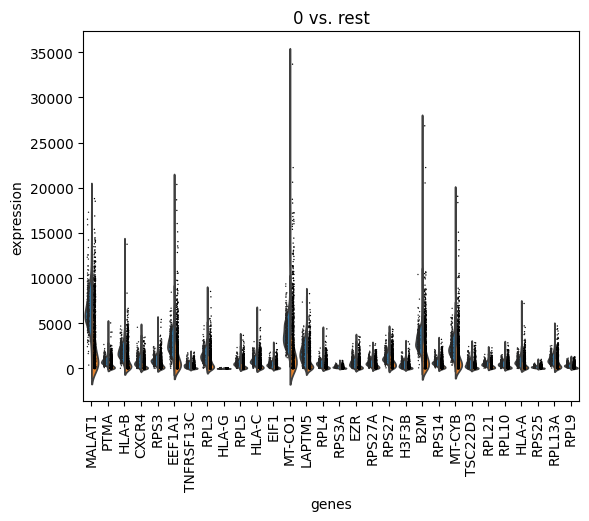

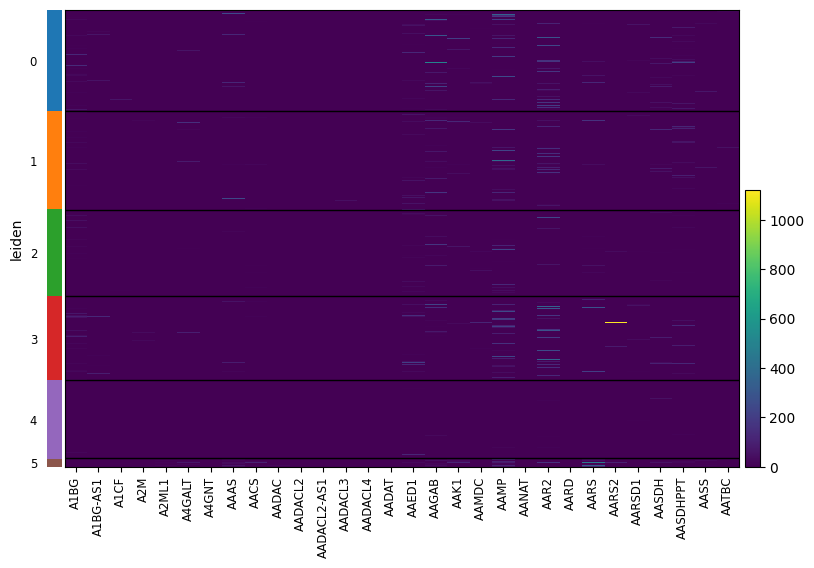

In [16]:
# List the first few gene names in your dataset
print(adata.var_names[:30])

# Perform differential expression analysis between clusters
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')

# Visualize the top marker genes for all clusters
sc.pl.rank_genes_groups(adata, n_genes=30, sharey=False)

# Violin plot for a specific cluster
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=30)

# Heatmap of the top genes
sc.pl.heatmap(adata, var_names=adata.var_names[:30], groupby='leiden', cmap='viridis')

# Save the final analysis results
adata.write('final_analysis_results.h5ad')


**VI. Cluster Proportion Analysis and Functional Enrichment of Marker Genes**


**Calculate Proportions of Each Cluster Within Treatment Groups:**

    This step calculates the proportions of each identified cluster within different treatment groups. It provides insights into how clusters (or cell populations) are distributed across the different experimental or treatment conditions. The proportions are calculated by grouping the data by the 'treatment' and 'leiden' columns and normalizing the counts within each treatment group.

**Install GProfiler Package:**

    This step installs the gprofiler-official Python package, which is used for gene list enrichment analysis. GProfiler enables the functional interpretation of gene lists by identifying enriched biological pathways, processes, and gene ontologies.

**Perform Enrichment Analysis with GProfiler:**

    This step performs functional enrichment analysis using GProfiler on the top marker genes identified from previous analyses. The analysis identifies biological pathways and gene ontologies that are statistically overrepresented in the list of marker genes. The results highlight which biological functions or processes are significantly associated with the clusters.

**Check the Structure of the Enrichment Results:**

    This step inspects the structure of the enrichment results obtained from GProfiler. It displays the first few rows of the results and lists the column names, ensuring that the output is correctly formatted and contains the expected information (e.g., p-values, pathway names).

**Calculate and Log Transform p-values:**

    This step calculates the negative logarithm of the p-values (-log10(p-value)) from the enrichment results. The log transformation makes it easier to visualize the significance of the enrichment results in subsequent steps, especially when creating plots or graphs. This transformation is particularly useful for highlighting very small p-values, which indicate strong statistical significance.


/tmp/ipykernel_36/1682345822.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  proportions = adata.obs.groupby(['treatment', 'leiden']).size().unstack(fill_value=0)


leiden            0         1         2         3         4         5
treatment                                                            
CONTROL    0.258359  0.205167  0.186930  0.161094  0.168693  0.019757
CVID       0.188133  0.224313  0.192475  0.204052  0.173661  0.017366
                                                name       p_value  \
0                                 cytosolic ribosome  5.461662e-43   
1                           Peptide chain elongation  4.735962e-40   
2                  Eukaryotic Translation Elongation  1.659868e-39   
3                             Viral mRNA Translation  1.013963e-37   
4                           Selenocysteine synthesis  3.349519e-37   
5                 Eukaryotic Translation Termination  3.349519e-37   
6  Nonsense Mediated Decay (NMD) independent of t...  5.955411e-37   
7  Response of EIF2AK4 (GCN2) to amino acid defic...  3.090480e-36   
8           Formation of a pool of free 40S subunits  3.090480e-36   
9                   

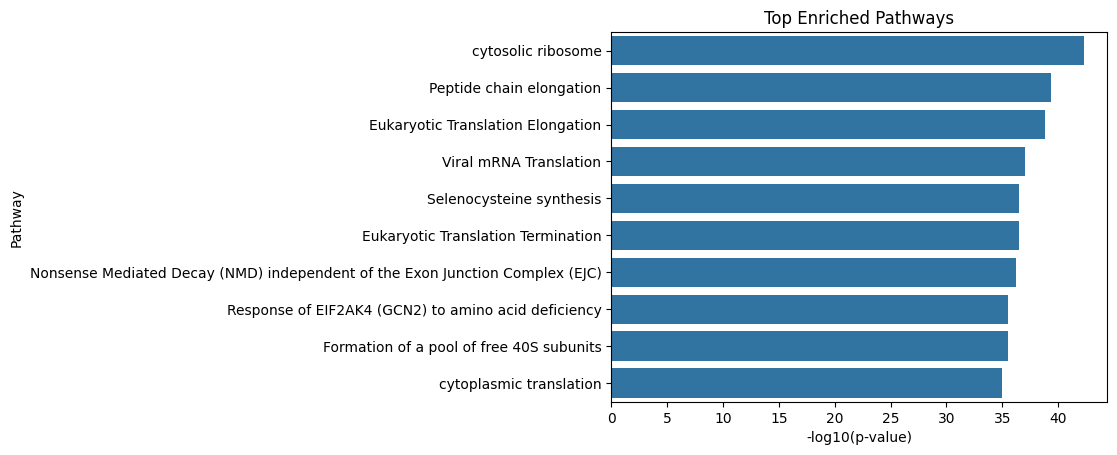

In [17]:
# Calculate proportions of each cluster within the 'treatment' groups
proportions = adata.obs.groupby(['treatment', 'leiden']).size().unstack(fill_value=0)
proportions = proportions.div(proportions.sum(axis=1), axis=0)
print(proportions)

# Install GProfiler package
!pip install gprofiler-official

from gprofiler import GProfiler

# Initialize GProfiler
gp = GProfiler(return_dataframe=True)

# Ensure marker_genes is a list of strings
marker_genes = list(adata.uns['rank_genes_groups']['names']['0'][:50])

# Perform enrichment analysis
enrichment_results = gp.profile(organism='hsapiens', query=marker_genes)

# Display top enriched pathways or GO terms
print(enrichment_results[['name', 'p_value', 'description']].head(10))

# Check the structure of the enrichment results
print(enrichment_results.head())
print(enrichment_results.columns)

# Calculate and log transform p-values
if 'p_value' in enrichment_results.columns:
    enrichment_results['log10_p_value'] = -np.log10(enrichment_results['p_value'])
else:
    print("The 'p_value' column is missing in the enrichment results.")

    
# Plot top enriched pathways
sns.barplot(x='log10_p_value', y='name', data=enrichment_results.head(10))
plt.title('Top Enriched Pathways')
plt.xlabel('-log10(p-value)')
plt.ylabel('Pathway')
plt.show()    

**VII. Visualization and Analysis of Cluster Proportions and Differentially Expressed Genes**

**Bar Plot for Visualizing Proportions:**

    This step generates a bar plot to visualize the proportions of different cell types (clusters) across various treatment conditions. The plot is stacked, allowing for an easy comparison of how each cluster is represented within each treatment group. This helps in understanding the distribution and compositional differences across conditions.

**Extract and Display Top Differentially Expressed Genes:**

    This step extracts the top 50 differentially expressed genes from a specific cluster (in this case, cluster 0). The extracted information includes gene names, log fold changes, and p-values, which are important for assessing the significance and magnitude of differential expression. The top genes are then displayed for review.

**Visualize Differentially Expressed Genes:**

    This step visualizes the top 20 differentially expressed genes in cluster 0 using a bar plot. The plot displays the log fold changes of these genes, allowing for a clear comparison of the most significantly altered genes within the cluster. The visualization highlights key genes that might be driving the biological differences observed in the cluster.

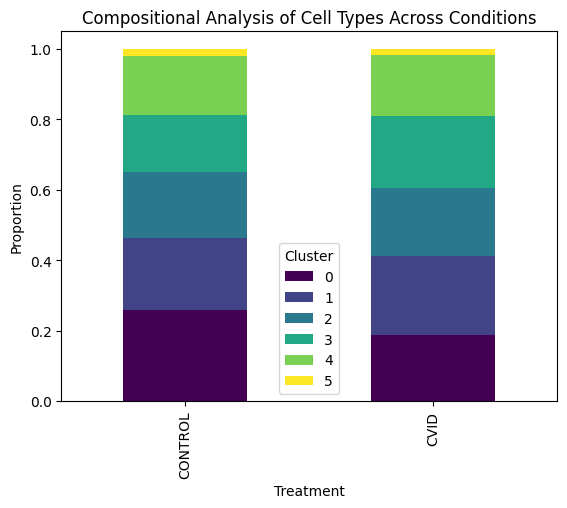

         gene  logfoldchange         pvals
0      MALAT1            NaN  1.076214e-55
1        PTMA            inf  1.155893e-45
2       HLA-B            NaN  1.484834e-44
3       CXCR4            inf  6.803673e-44
4        RPS3            inf  4.716442e-43
5      EEF1A1            NaN  2.937967e-41
6   TNFRSF13C     298.990936  3.452362e-41
7        RPL3            NaN  6.731314e-41
8       HLA-G       5.980495  1.009442e-39
9        RPL5     371.034271  1.436752e-39
10      HLA-C            inf  1.510493e-39
11       EIF1     315.546265  2.421633e-39
12     MT-CO1            NaN  4.017146e-39
13     LAPTM5            NaN  4.374120e-39
14       RPL4     338.745514  1.160225e-38
15      RPS3A     103.412697  7.977181e-38
16        EZR     453.034546  1.445552e-37
17     RPS27A     376.841736  1.862093e-37
18      RPS27            NaN  2.812954e-37
19      H3F3B     333.325104  3.356940e-37
20        B2M            NaN  5.816420e-37
21      RPS14            inf  4.437065e-36
22     MT-C

/tmp/ipykernel_36/687007696.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='gene', x='logfoldchange', data=top_genes.head(20), palette='viridis')


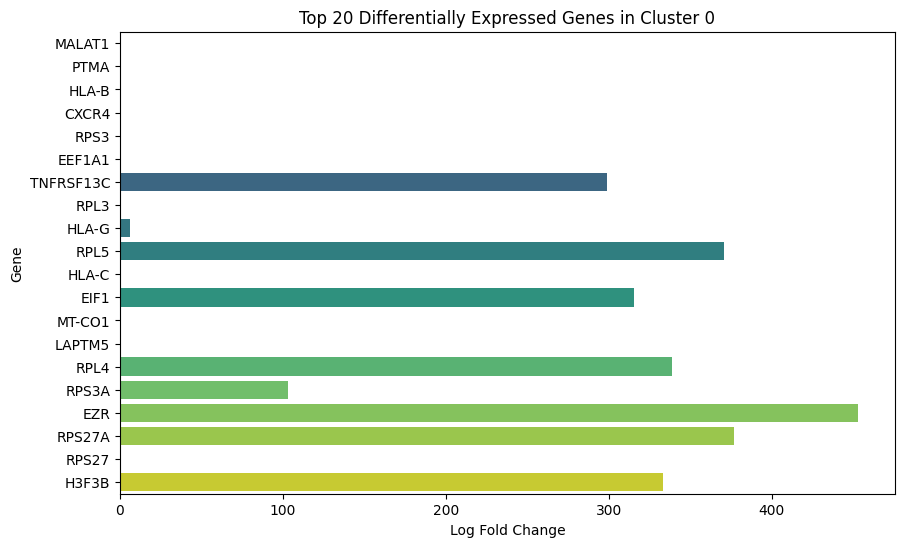

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Bar plot for visualizing proportions
proportions.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Compositional Analysis of Cell Types Across Conditions')
plt.xlabel('Treatment')
plt.ylabel('Proportion')
plt.legend(title='Cluster')
plt.show()

# Extract top differentially expressed genes from cluster 0
top_genes = pd.DataFrame({
    'gene': adata.uns['rank_genes_groups']['names']['0'][:50],
    'logfoldchange': adata.uns['rank_genes_groups']['logfoldchanges']['0'][:50],
    'pvals': adata.uns['rank_genes_groups']['pvals']['0'][:50]
})

# Display the top genes
print(top_genes)

# Visualize the log fold changes of the top 20 differentially expressed genes
plt.figure(figsize=(10, 6))
sns.barplot(y='gene', x='logfoldchange', data=top_genes.head(20), palette='viridis')
plt.title('Top 20 Differentially Expressed Genes in Cluster 0')
plt.xlabel('Log Fold Change')
plt.ylabel('Gene')
plt.show()


**VIII. Cluster Evaluation and Composition Analysis**

**Standardize Features for Clustering:**

    This step involves selecting key features from the enrichment results and standardizing them using StandardScaler. Standardization ensures that all features are on the same scale, which is crucial for effective clustering.
   

In [19]:
from sklearn.preprocessing import StandardScaler

features = enrichment_results[['log10_p_value', 'term_size', 'intersection_size']]
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

print("Scaled features for clustering:")
print(features_scaled[:5])


Scaled features for clustering:
[[ 3.90012845 -0.49533931  0.96273481]
 [ 3.57436037 -0.50562532  0.96273481]
 [ 3.5139691  -0.50410146  0.96273481]
 [ 3.31594715 -0.50562532  0.87019039]
 [ 3.25840597 -0.50410146  0.87019039]]


**K-Means Clustering:**

    The K-means algorithm is applied to the standardized features to partition the data into a specified number of clusters. The resulting cluster labels are then added to the enrichment results for further analysis.
   

In [20]:
from sklearn.cluster import KMeans

n_clusters = 3  # Adjust based on your dataset
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(features_scaled)

enrichment_results['cluster'] = clusters

print(enrichment_results[['name', 'log10_p_value', 'cluster']].head())


                                name  log10_p_value  cluster
0                 cytosolic ribosome      42.262675        2
1           Peptide chain elongation      39.324592        2
2  Eukaryotic Translation Elongation      38.779926        2
3             Viral mRNA Translation      36.993978        2
4           Selenocysteine synthesis      36.475018        2


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


**PCA and Visualization:**

    Principal Component Analysis (PCA) is used to reduce the dimensionality of the data to two components, which are then plotted to visualize the clusters identified by K-means. This step provides a visual summary of the clustering results.

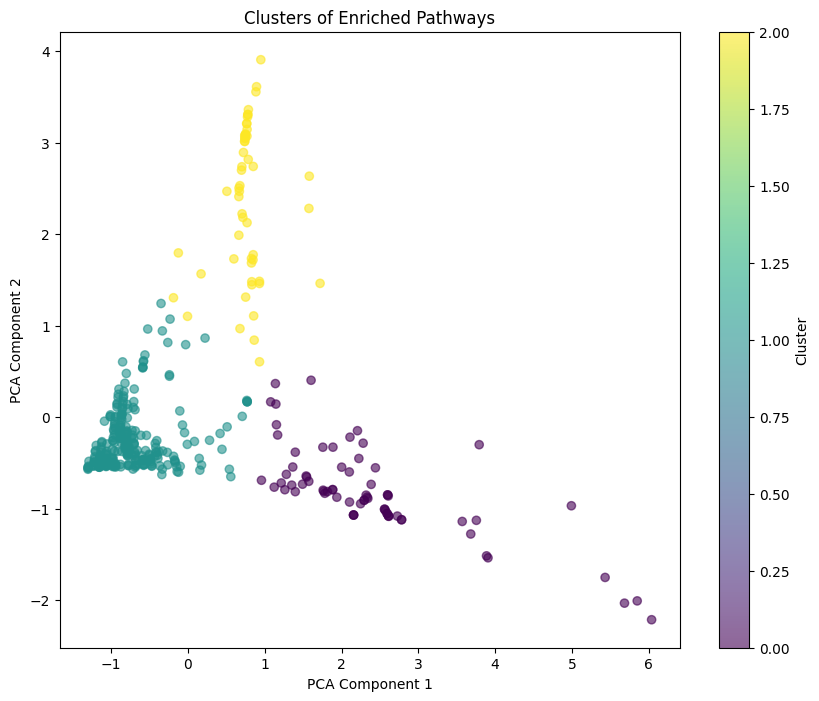

In [21]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
pca_result = pca.fit_transform(features_scaled)

plt.figure(figsize=(10, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=clusters, cmap='viridis', alpha=0.6)
plt.title('Clusters of Enriched Pathways')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()


**IX. Cluster Analysis, Pathway Prioritization, and Visualization**

**Print Pathways in Each Cluster:**

     Listing all pathways associated with each cluster. It's a simple output that helps in understanding which pathways are grouped together in each cluster. Listing pathways assigned to each cluster based on K-means clustering.

In [22]:
for cluster_id in enrichment_results['cluster'].unique():
    print(f"\nCluster {cluster_id} Pathways:")
    cluster_pathways = enrichment_results[enrichment_results['cluster'] == cluster_id]['name']
    for pathway in cluster_pathways:
        print(f"- {pathway}")



Cluster 2 Pathways:
- cytosolic ribosome
- Peptide chain elongation
- Eukaryotic Translation Elongation
- Viral mRNA Translation
- Selenocysteine synthesis
- Eukaryotic Translation Termination
- Nonsense Mediated Decay (NMD) independent of the Exon Junction Complex (EJC)
- Response of EIF2AK4 (GCN2) to amino acid deficiency
- Formation of a pool of free 40S subunits
- cytoplasmic translation
- L13a-mediated translational silencing of Ceruloplasmin expression
- GTP hydrolysis and joining of the 60S ribosomal subunit
- SRP-dependent cotranslational protein targeting to membrane
- ribosomal subunit
- Cytoplasmic ribosomal proteins
- Nonsense Mediated Decay (NMD) enhanced by the Exon Junction Complex (EJC)
- Nonsense-Mediated Decay (NMD)
- Selenoamino acid metabolism
- Eukaryotic Translation Initiation
- Cap-dependent Translation Initiation
- Influenza Viral RNA Transcription and Replication
- Regulation of expression of SLITs and ROBOs
- Influenza Infection
- Signaling by ROBO receptors


**Print Top Pathways by P-Value in Each Cluster:**

    For each cluster, the pathways are sorted by p-value, and the top pathways with the most significant p-values are printed. This helps in identifying the most relevant pathways in each cluster.



In [23]:
for cluster_id in enrichment_results['cluster'].unique():
    print(f"\nTop Pathways in Cluster {cluster_id}:")
    cluster_pathways = enrichment_results[enrichment_results['cluster'] == cluster_id]
    top_pathways = cluster_pathways.sort_values(by='p_value').head(10)
    for _, row in top_pathways.iterrows():
        print(f"- {row['name']} (p-value: {row['p_value']})")



Top Pathways in Cluster 2:
- cytosolic ribosome (p-value: 5.461662442596101e-43)
- Peptide chain elongation (p-value: 4.735961796215029e-40)
- Eukaryotic Translation Elongation (p-value: 1.6598679927614936e-39)
- Viral mRNA Translation (p-value: 1.013962620870568e-37)
- Selenocysteine synthesis (p-value: 3.349519184607107e-37)
- Eukaryotic Translation Termination (p-value: 3.349519184607107e-37)
- Nonsense Mediated Decay (NMD) independent of the Exon Junction Complex (EJC) (p-value: 5.9554112026387966e-37)
- Response of EIF2AK4 (GCN2) to amino acid deficiency (p-value: 3.090479572850497e-36)
- Formation of a pool of free 40S subunits (p-value: 3.090479572850497e-36)
- cytoplasmic translation (p-value: 1.0934232112947583e-35)

Top Pathways in Cluster 1:
- SARS-CoV-1 modulates host translation machinery (p-value: 1.7105777997233624e-18)
- SARS-CoV-1-host interactions (p-value: 1.3048859313878227e-16)
- cytosolic small ribosomal subunit (p-value: 4.893170135001405e-16)
- 60S ribosomal su

**Calculate Composite Score and Print Top Pathways:**

     A composite score is calculated for each pathway, combining p-value, intersection size, and term size. The pathways in each cluster are then sorted by this composite score, and the top pathways are printed.

In [24]:
enrichment_results['composite_score'] = (
    enrichment_results['log10_p_value'] * enrichment_results['intersection_size'] / enrichment_results['term_size']
)

for cluster_id in enrichment_results['cluster'].unique():
    print(f"\nTop Pathways in Cluster {cluster_id}:")
    cluster_pathways = enrichment_results[enrichment_results['cluster'] == cluster_id]
    top_pathways = cluster_pathways.sort_values(by='composite_score', ascending=False).head(10)
    for _, row in top_pathways.iterrows():
        print(f"- {row['name']} (Composite Score: {row['composite_score']:.2f})")



Top Pathways in Cluster 2:
- Peptide chain elongation (Composite Score: 10.92)
- Eukaryotic Translation Elongation (Composite Score: 10.31)
- Viral mRNA Translation (Composite Score: 9.87)
- Cytoplasmic ribosomal proteins (Composite Score: 9.33)
- Selenocysteine synthesis (Composite Score: 9.31)
- Eukaryotic Translation Termination (Composite Score: 9.31)
- Nonsense Mediated Decay (NMD) independent of the Exon Junction Complex (EJC) (Composite Score: 9.06)
- cytosolic ribosome (Composite Score: 9.03)
- Ribosome, cytoplasmic (Composite Score: 8.47)
- Response of EIF2AK4 (GCN2) to amino acid deficiency (Composite Score: 8.36)

Top Pathways in Cluster 1:
- MHC class I protein complex (Composite Score: 9.22)
- SARS-CoV-1 modulates host translation machinery (Composite Score: 5.76)
- Endosomal/Vacuolar pathway (Composite Score: 5.11)
- 60S ribosomal subunit, cytoplasmic (Composite Score: 4.44)
- protection from natural killer cell mediated cytotoxicity (Composite Score: 4.13)
- cytosolic s

**Inspect Enrichment Results Data:**

    This step provides a quick inspection of the enrichment results, including a preview of the data and a check of the data types to ensure that everything is correctly formatted for further analysis.
   

In [25]:
print(enrichment_results.head())
print(enrichment_results.dtypes)


  source              native                               name       p_value  \
0  GO:CC          GO:0022626                 cytosolic ribosome  5.461662e-43   
1   REAC   REAC:R-HSA-156902           Peptide chain elongation  4.735962e-40   
2   REAC   REAC:R-HSA-156842  Eukaryotic Translation Elongation  1.659868e-39   
3   REAC   REAC:R-HSA-192823             Viral mRNA Translation  1.013963e-37   
4   REAC  REAC:R-HSA-2408557           Selenocysteine synthesis  3.349519e-37   

   significant                                        description  term_size  \
0         True  "A ribosome located in the cytosol." [GOC:mtg_...        117   
1         True                           Peptide chain elongation         90   
2         True                  Eukaryotic Translation Elongation         94   
3         True                             Viral mRNA Translation         90   
4         True                           Selenocysteine synthesis         94   

   query_size  intersection_size

**Plot Top Pathways for a Single Cluster:**

    The top 10 pathways in a specific cluster (e.g., cluster 0) are visualized using a bar plot, with pathways sorted by p-value. This visualization focuses on the most significant pathways in a particular cluster.
    

/tmp/ipykernel_36/4176498929.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='log10_p_value', y='name', data=top_pathways, palette='viridis')


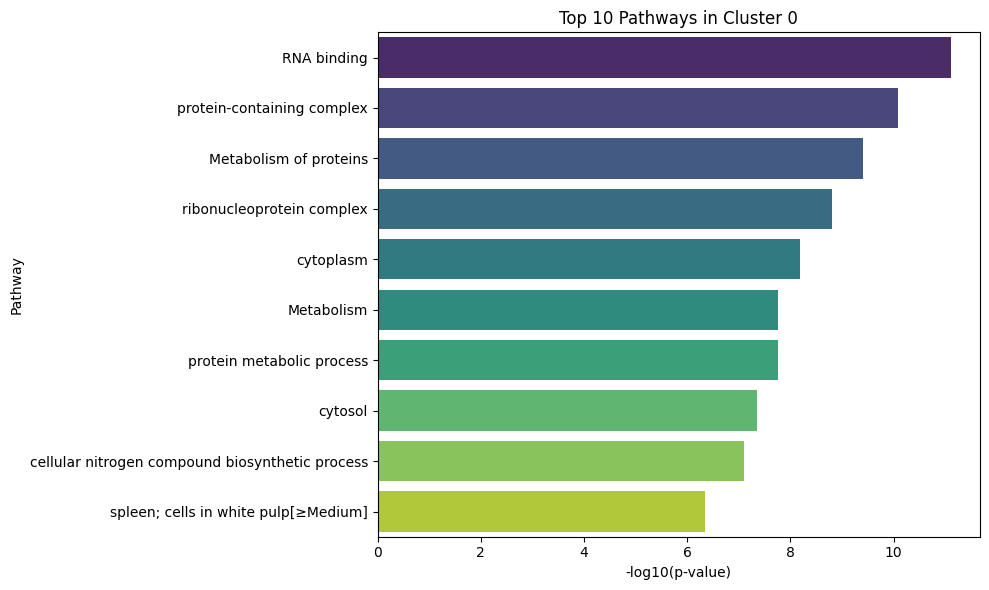

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

cluster_id = 0
cluster_pathways = enrichment_results[enrichment_results['cluster'] == cluster_id]
top_pathways = cluster_pathways.sort_values(by='p_value').head(10)

if not top_pathways.empty:
    plt.figure(figsize=(10, 6))
    sns.barplot(x='log10_p_value', y='name', data=top_pathways, palette='viridis')
    plt.title(f'Top 10 Pathways in Cluster {cluster_id}')
    plt.xlabel('-log10(p-value)')
    plt.ylabel('Pathway')
    plt.tight_layout()
    plt.show()
else:
    print(f"No significant pathways found in Cluster {cluster_id}.")


**Function for Plotting Top Pathways Across Clusters:**

    This function plots the top pathways for each cluster across the entire dataset, sorted by p-value. It provides a broader view of the significant pathways in each cluster.
    

/tmp/ipykernel_36/1409772970.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='log10_p_value', y='name', data=top_pathways, palette='viridis')


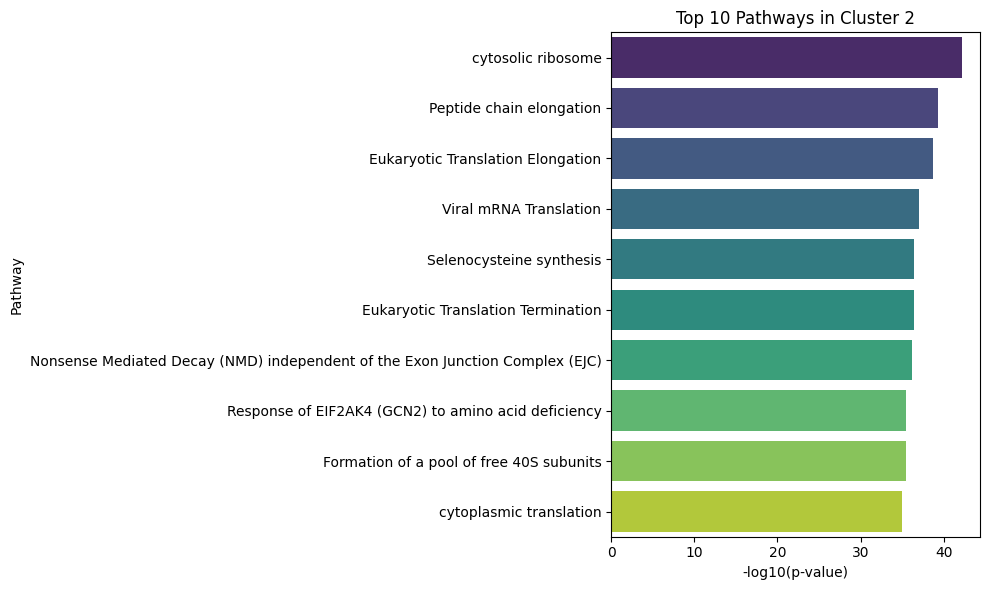

/tmp/ipykernel_36/1409772970.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='log10_p_value', y='name', data=top_pathways, palette='viridis')


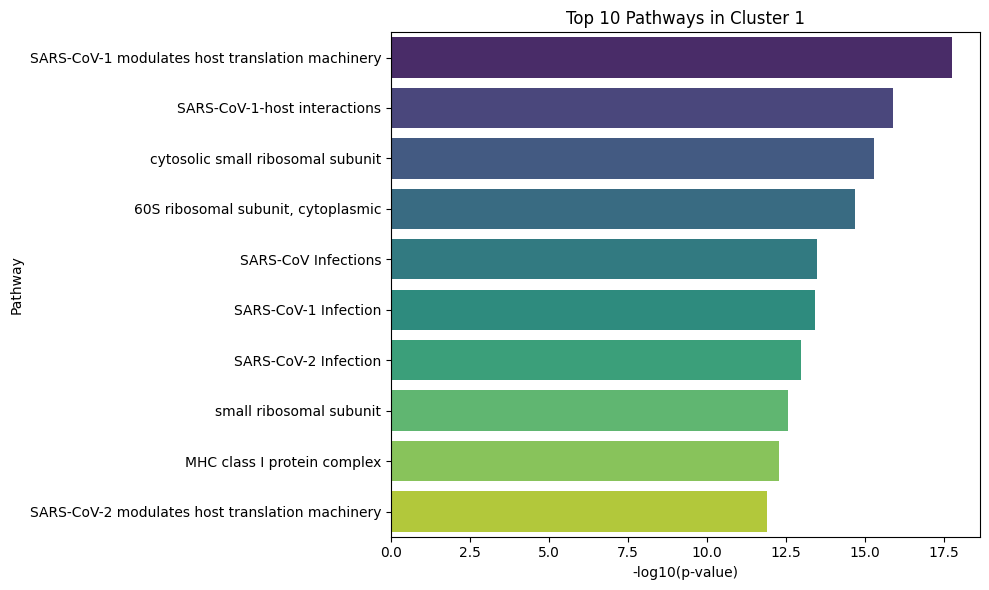

/tmp/ipykernel_36/1409772970.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='log10_p_value', y='name', data=top_pathways, palette='viridis')


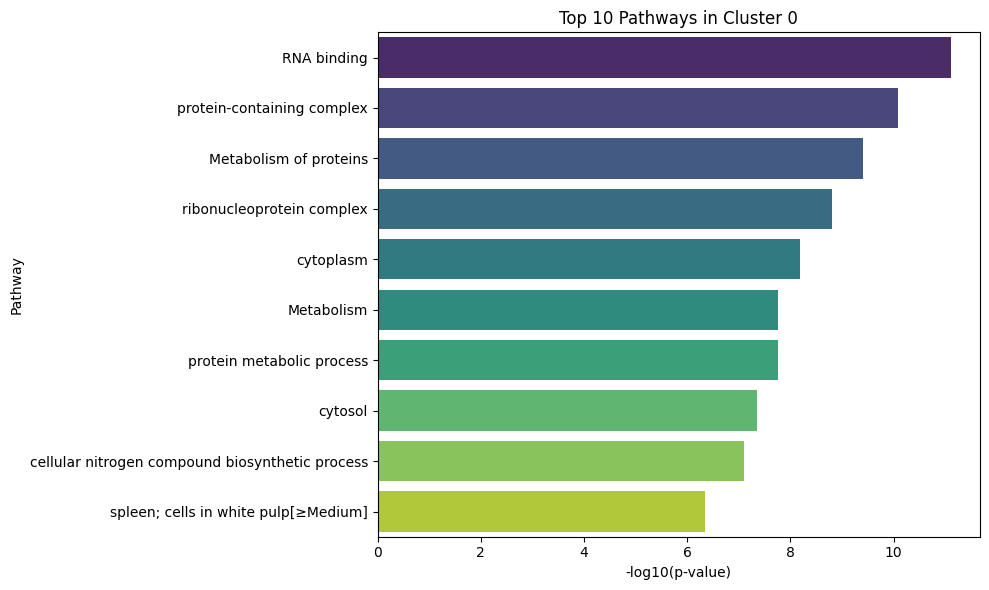

In [27]:
def plot_top_pathways_by_pvalue(enrichment_results, top_n=10):
    clusters = enrichment_results['cluster'].unique()
    for cluster_id in clusters:
        cluster_pathways = enrichment_results[enrichment_results['cluster'] == cluster_id]
        top_pathways = cluster_pathways.sort_values(by='p_value').head(top_n)
        if not top_pathways.empty:
            plt.figure(figsize=(10, 6))
            sns.barplot(x='log10_p_value', y='name', data=top_pathways, palette='viridis')
            plt.title(f'Top {top_n} Pathways in Cluster {cluster_id}')
            plt.xlabel('-log10(p-value)')
            plt.ylabel('Pathway')
            plt.tight_layout()
            plt.show()

plot_top_pathways_by_pvalue(enrichment_results)


**Interactive Visualization :**

     This step creates an interactive scatter plot using Plotly to visualize the PCA results and clusters. The interactive features allow for a more in-depth exploration of the clustered pathways, including detailed information on each point.
    

In [28]:
import pandas as pd
import plotly.express as px
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(features_scaled)

pca_df = pd.DataFrame({
    'PCA1': pca_result[:, 0],
    'PCA2': pca_result[:, 1],
    'Cluster': enrichment_results['cluster'].astype(str),
    'Pathway': enrichment_results['name'],
    'Source': enrichment_results['source'],
    '-log10(p-value)': enrichment_results['log10_p_value']
})

fig = px.scatter(
    pca_df, x='PCA1', y='PCA2',
    color='Cluster',
    hover_data=['Pathway', 'Source', '-log10(p-value)'],
    title='2D PCA of Enriched Pathways Clusters',
    width=900, height=600
)

fig.update_traces(marker=dict(size=12, line=dict(width=1, color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

fig.update_layout(
    legend_title_text='Cluster',
    xaxis_title='PCA Component 1',
    yaxis_title='PCA Component 2'
)

fig.show()


**X. Model Validation**

**Calculate Silhouette Score and WCSS:**

     The silhouette score is calculated to assess the quality of the clustering, indicating how well-separated the clusters are. The within-cluster sum of squares (WCSS) is also computed to measure the compactness of the clusters.

In [29]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(features_scaled, enrichment_results['cluster'])
print(f"Silhouette Score: {silhouette_avg}")

wcss = 0
for i in range(n_clusters):
    points = features_scaled[enrichment_results['cluster'] == i]
    centroid = kmeans.cluster_centers_[i]
    wcss += ((points - centroid) ** 2).sum()

print(f"Within-cluster sum of squares (WCSS): {wcss}")


Silhouette Score: 0.7090904041812841
Within-cluster sum of squares (WCSS): 253.44388786912046


**Cluster Composition Analysis:**

     This step analyzes the number of pathways in each cluster and visualizes the cluster composition using a bar plot. It provides an overview of how the pathways are distributed across clusters.

         K-means
cluster         
0             71
1            281
2             55


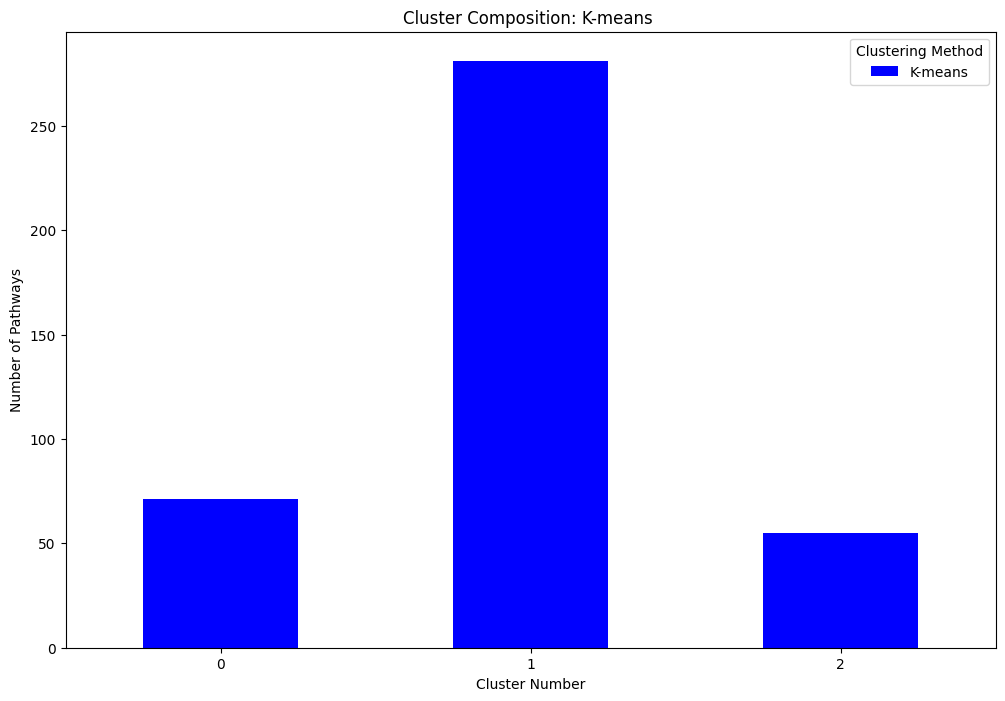

In [30]:
kmeans_counts = enrichment_results['cluster'].value_counts().sort_index()

cluster_comparison = pd.DataFrame({
    'K-means': kmeans_counts
})

print(cluster_comparison)

cluster_comparison.plot(kind='bar', figsize=(12, 8), color=['blue', 'orange'])
plt.title('Cluster Composition: K-means ')
plt.xlabel('Cluster Number')
plt.ylabel('Number of Pathways')
plt.xticks(rotation=0)
plt.legend(title='Clustering Method')
plt.show()
